In [3]:
# Importing necessary libraries
import numpy as np  # For numerical computations
import pandas as pd  # For data manipulation
import matplotlib.pyplot as plt  # For data visualization
import tensorflow as tf  # For deep learning models
from tensorflow import keras  # Keras API for TensorFlow
from sklearn.model_selection import TimeSeriesSplit  # For time series cross-validation
from tensorflow.keras.layers import Dense, LSTM  # Layers for building neural networks
from keras.callbacks import EarlyStopping  # Callback for early stopping in Keras
from sklearn.preprocessing import MinMaxScaler  # For feature scaling
from sklearn.model_selection import train_test_split  # For splitting data into train and test sets
from sklearn.metrics import r2_score  # Evaluation metric: R-squared score

import os  # For interacting with the operating system

# Iterating through files in a directory (if applicable)
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))  # Printing file paths

/kaggle/input/rossmann-store-sales/sample_submission.csv
/kaggle/input/rossmann-store-sales/store.csv
/kaggle/input/rossmann-store-sales/train.csv
/kaggle/input/rossmann-store-sales/test.csv


In [4]:
# Load the training dataset with specified options
df_train = pd.read_csv('/kaggle/input/rossmann-store-sales/train.csv', low_memory=False, parse_dates=["Date"])

# Load the store dataset
df_store = pd.read_csv('/kaggle/input/rossmann-store-sales/store.csv')

# Merge the datasets on the 'Store' column using inner join
df_com = pd.merge(df_train, df_store, on='Store', how='inner')

In [5]:
# Display the first 500 rows of the merged dataset
df_com.head(500)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,5,2015-07-31,10834,926,1,1,0,1,d,c,2780.0,6.0,2015.0,0,NaN,NaN,NaN
496,497,5,2015-07-31,11353,1248,1,1,0,1,a,c,1610.0,NaN,NaN,0,NaN,NaN,NaN
497,498,5,2015-07-31,7685,903,1,1,0,0,a,a,990.0,NaN,NaN,1,40.0,2014.0,"Jan,Apr,Jul,Oct"
498,499,5,2015-07-31,7716,922,1,1,0,1,c,c,450.0,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [6]:
# Check for null values in the merged dataset
df_com.isnull().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64

In [7]:
# Fill missing values in specific columns with 0 using the recommended approach
df_com['Promo2SinceWeek'] = df_com['Promo2SinceWeek'].fillna(0)
df_com['Promo2SinceYear'] = df_com['Promo2SinceYear'].fillna(0)
df_com['PromoInterval'] = df_com['PromoInterval'].fillna(0)

# Check for null values again after filling missing values
df_com.isnull().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek                   0
Promo2SinceYear                   0
PromoInterval                     0
dtype: int64

In [8]:
# Fill missing values in 'CompetitionDistance' column with 0 using the recommended approach
df_com['CompetitionDistance'] = df_com['CompetitionDistance'].fillna(0)

# Identify rows where 'CompetitionDistance' was filled with 0
filled_with_zero = df_com['CompetitionDistance'] == 0

# Fill corresponding rows in 'CompetitionOpenSinceMonth' and 'CompetitionOpenSinceYear' with 0
df_com.loc[filled_with_zero, 'CompetitionOpenSinceMonth'] = 0
df_com.loc[filled_with_zero, 'CompetitionOpenSinceYear'] = 0

# Check for null values again after filling missing values
df_com.isnull().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance               0
CompetitionOpenSinceMonth    320706
CompetitionOpenSinceYear     320706
Promo2                            0
Promo2SinceWeek                   0
Promo2SinceYear                   0
PromoInterval                     0
dtype: int64

In [9]:
# Fill missing values in 'CompetitionOpenSinceMonth' and 'CompetitionOpenSinceYear' with their respective modes using the recommended approach
df_com['CompetitionOpenSinceMonth'] = df_com['CompetitionOpenSinceMonth'].fillna(df_com['CompetitionOpenSinceMonth'].mode()[0])
df_com['CompetitionOpenSinceYear'] = df_com['CompetitionOpenSinceYear'].fillna(df_com['CompetitionOpenSinceYear'].mode()[0])

# Check for null values again after filling missing values
df_com.isnull().sum()

Store                        0
DayOfWeek                    0
Date                         0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [10]:
# Display information about the dataframe
df_com.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  int64         
 4   Customers                  1017209 non-null  int64         
 5   Open                       1017209 non-null  int64         
 6   Promo                      1017209 non-null  int64         
 7   StateHoliday               1017209 non-null  object        
 8   SchoolHoliday              1017209 non-null  int64         
 9   StoreType                  1017209 non-null  object        
 10  Assortment                 1017209 non-null  object        
 11  CompetitionDistance        1017209 no

In [11]:
# Convert the 'Date' column to datetime format
df_com['Date'] = pd.to_datetime(df_com['Date'])

# Set 'Date' as the index and drop the original column
df_chg = df_com.set_index('Date', drop=True)

# Display the first few rows of the modified dataframe
df_chg.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
Date,,,,,,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2015-07-31,2,5,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2015-07-31,3,5,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
2015-07-31,4,5,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
2015-07-31,5,5,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0


In [12]:
# Display information about the modified dataframe
df_chg.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1017209 entries, 2015-07-31 to 2013-01-01
Data columns (total 17 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Sales                      1017209 non-null  int64  
 3   Customers                  1017209 non-null  int64  
 4   Open                       1017209 non-null  int64  
 5   Promo                      1017209 non-null  int64  
 6   StateHoliday               1017209 non-null  object 
 7   SchoolHoliday              1017209 non-null  int64  
 8   StoreType                  1017209 non-null  object 
 9   Assortment                 1017209 non-null  object 
 10  CompetitionDistance        1017209 non-null  float64
 11  CompetitionOpenSinceMonth  1017209 non-null  float64
 12  CompetitionOpenSinceYear   1017209 non-null  float64
 1

In [13]:
# Print the number of unique values for each categorical variable
print(f"StateHoliday: {df_chg['StateHoliday'].nunique()}")
print(f"StoreType: {df_chg['StoreType'].nunique()}")
print(f"Assortment: {df_chg['Assortment'].nunique()}")
print(f"PromoInterval: {df_chg['PromoInterval'].nunique()}")

# Drop the categorical variables
df_chg = df_chg.drop(['StateHoliday', 'StoreType', 'Assortment', 'PromoInterval'], axis=1)

StateHoliday: 4
StoreType: 4
Assortment: 3
PromoInterval: 4


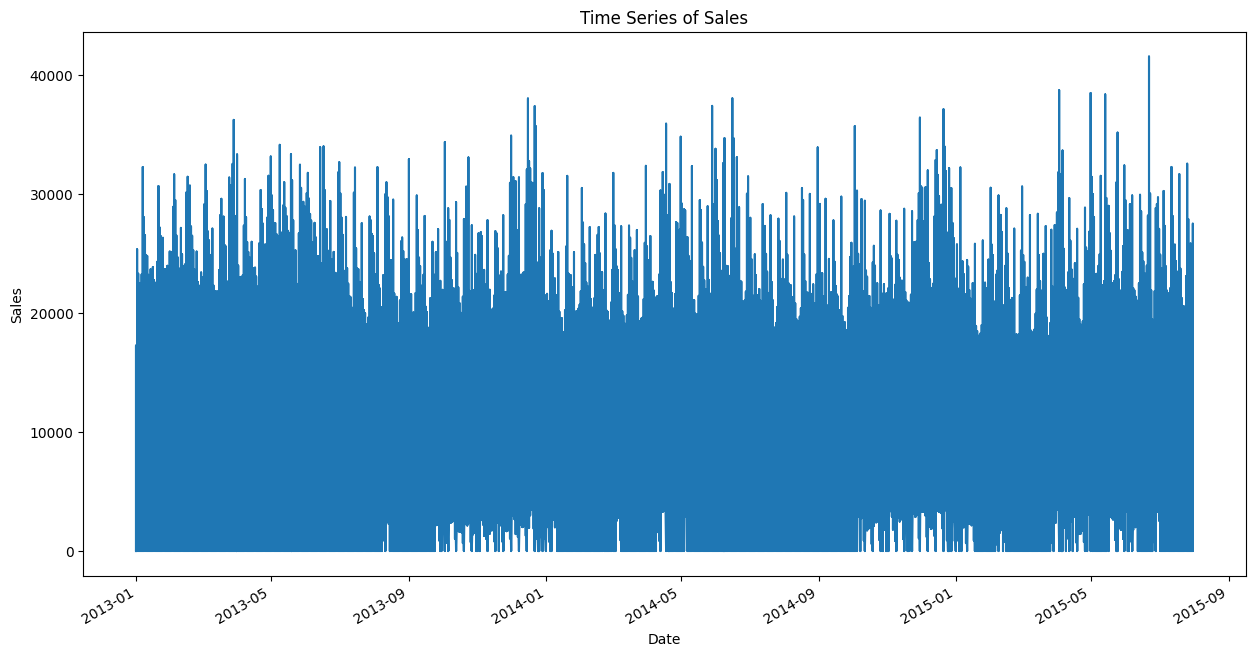

In [14]:
# Plot the time series of sales
plt.figure(figsize=(15,8))
df_chg['Sales'].plot()
plt.title('Time Series of Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

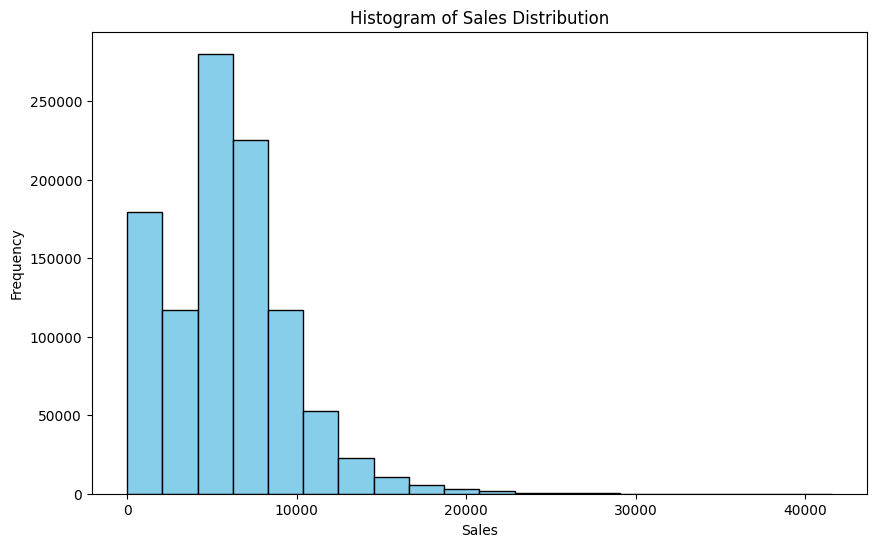

In [15]:
plt.figure(figsize=(10,6))
plt.hist(df_chg['Sales'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Sales Distribution')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

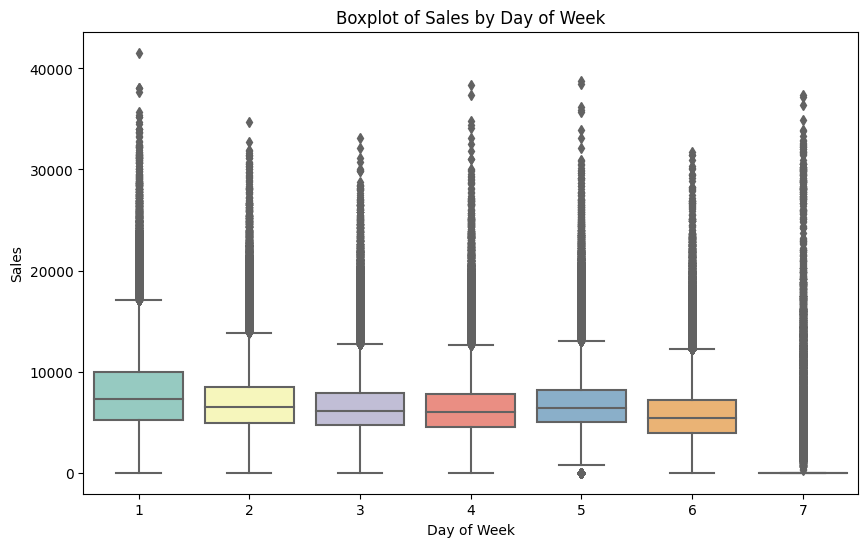

In [16]:
import seaborn as sns

plt.figure(figsize=(10,6))
sns.boxplot(x='DayOfWeek', y='Sales', data=df_chg, palette='Set3')
plt.title('Boxplot of Sales by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Sales')
plt.show()

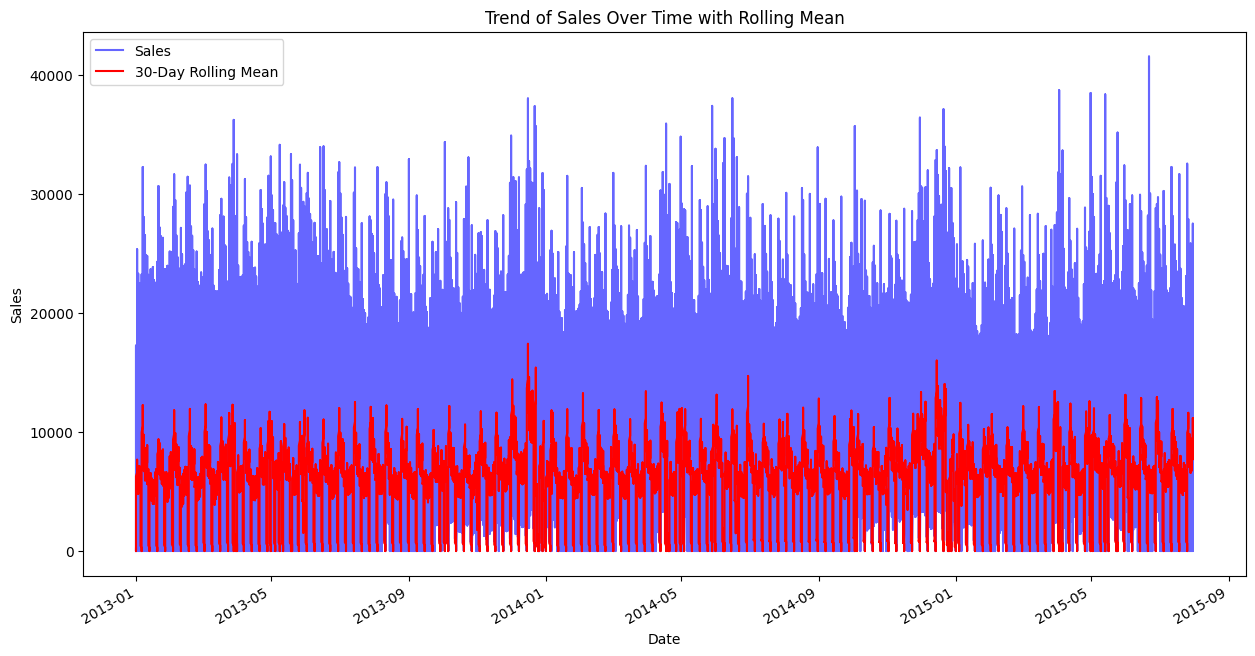

In [17]:
plt.figure(figsize=(15,8))
df_chg['Sales'].plot(label='Sales', color='blue', alpha=0.6)
df_chg['Sales'].rolling(window=30).mean().plot(label='30-Day Rolling Mean', color='red')
plt.title('Trend of Sales Over Time with Rolling Mean')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

<Figure size 1500x1000 with 0 Axes>

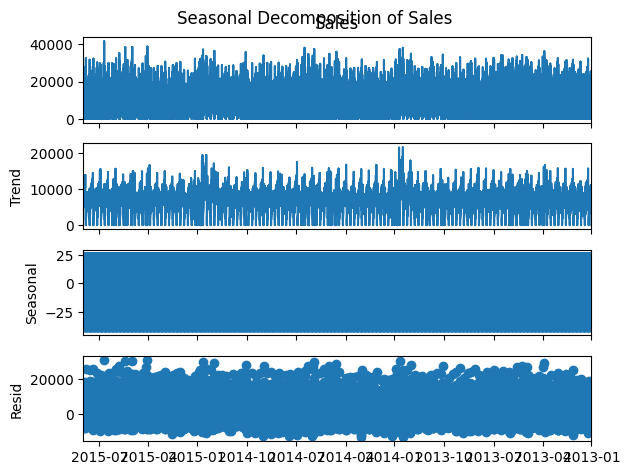

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose

plt.figure(figsize=(15,10))
decomposition = seasonal_decompose(df_chg['Sales'], period=7) # Assuming weekly seasonality
decomposition.plot()
plt.suptitle('Seasonal Decomposition of Sales')
plt.show()


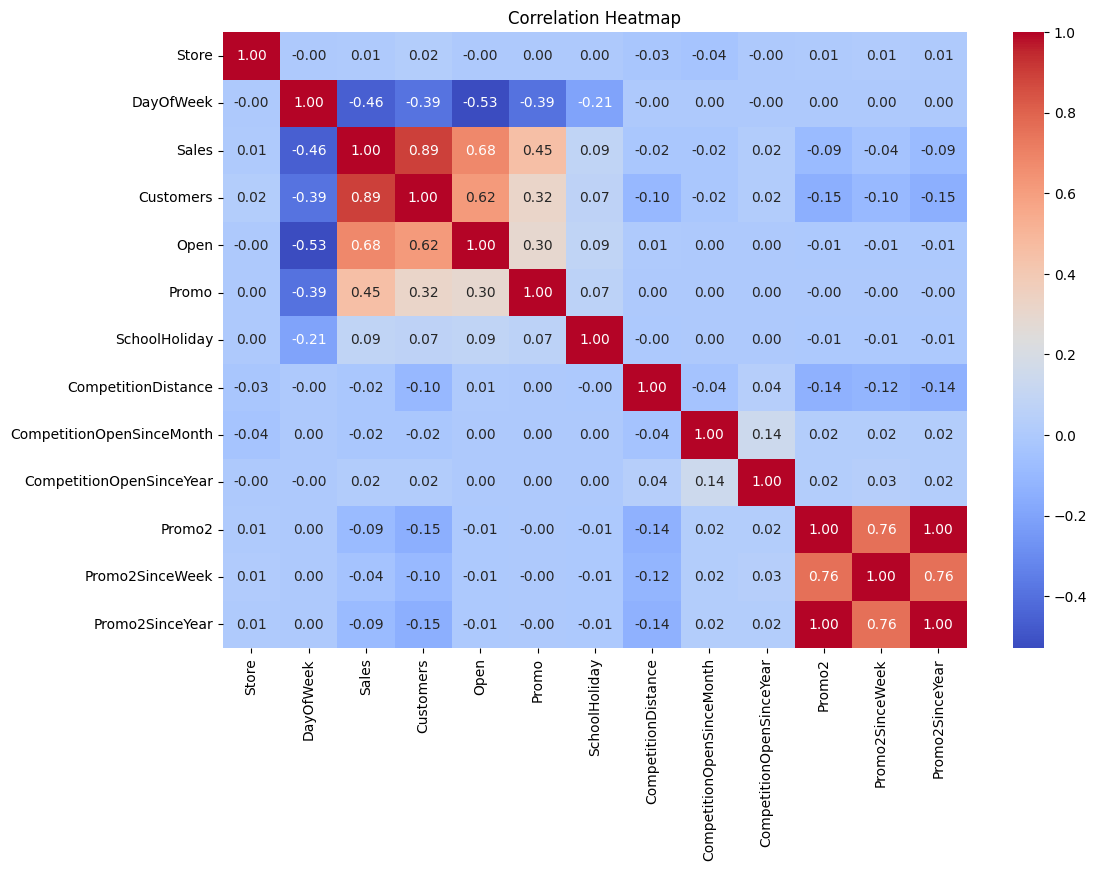

In [19]:
plt.figure(figsize=(12,8))
sns.heatmap(df_chg.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [20]:
tss = TimeSeriesSplit(n_splits=2)

# Sort time frame by time
df_chg.sort_index(inplace=True)

# Prepare features as data series
X = df_chg.drop(labels=['Sales'], axis=1)
y = df_chg['Sales']

# Split Train and test data
for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [21]:
X_train.index

DatetimeIndex(['2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01',
               ...
               '2014-09-13', '2014-09-13', '2014-09-13', '2014-09-13',
               '2014-09-13', '2014-09-13', '2014-09-13', '2014-09-13',
               '2014-09-13', '2014-09-13'],
              dtype='datetime64[ns]', name='Date', length=678140, freq=None)

In [22]:
X_test.index

DatetimeIndex(['2014-09-13', '2014-09-13', '2014-09-13', '2014-09-13',
               '2014-09-13', '2014-09-13', '2014-09-13', '2014-09-13',
               '2014-09-13', '2014-09-13',
               ...
               '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31'],
              dtype='datetime64[ns]', name='Date', length=339069, freq=None)

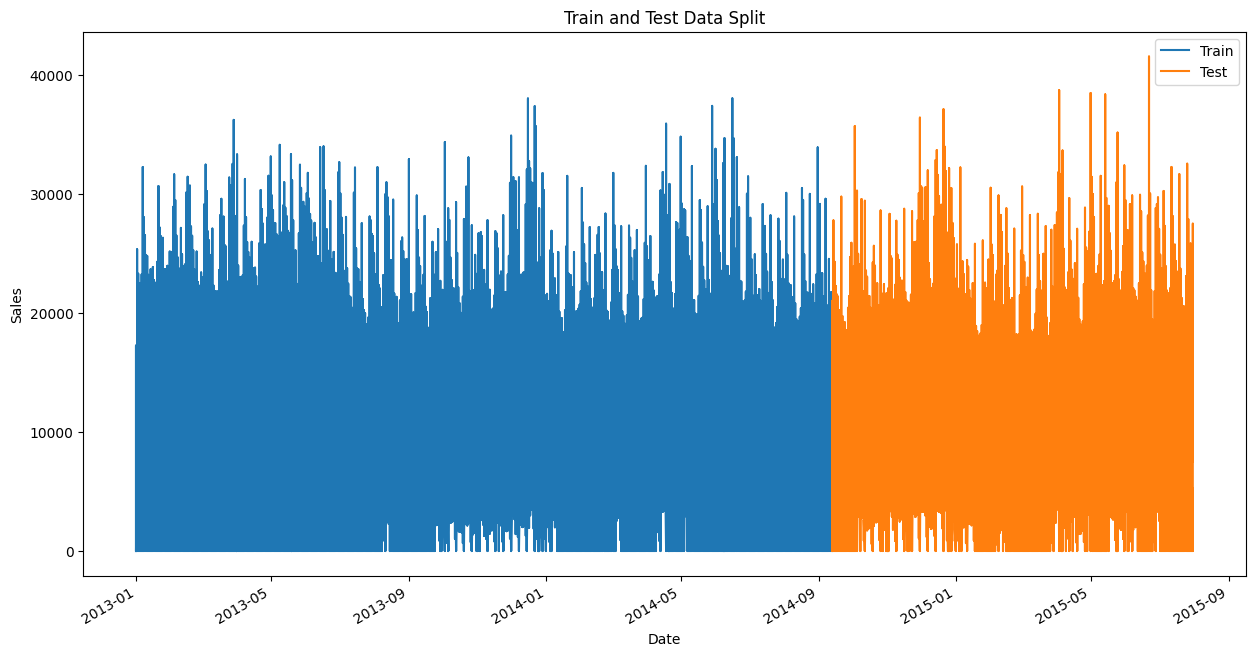

In [23]:
plt.figure(figsize=(15,8))
ax = y_train.plot()
y_test.plot(ax=ax)
plt.legend(['Train', 'Test'])
plt.title('Train and Test Data Split')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

In [24]:
# Reshape 1D array to 2D array (Not required as they are already reshaped earlier)
# y_train = np.array(y_train).reshape(-1,1)
# X_test = np.array(X_test).reshape(-1,1)

y_test = np.array(y_test).reshape(-1,1)
y_train = np.array(y_train).reshape(-1, 1)

# Scale the data
scaler_x = MinMaxScaler(feature_range=(-1, 1))  # Initialize MinMaxScaler for features
scaler_y = MinMaxScaler(feature_range=(-1, 1))  # Initialize MinMaxScaler for target
X_train_sc = scaler_x.fit_transform(X_train)    # Scale the training features
y_train_sc = scaler_y.fit_transform(y_train)    # Scale the training target
X_test_sc = scaler_x.fit_transform(X_test)      # Scale the test features (Note: Separate scaler for test data)
y_test_sc = scaler_y.fit_transform(y_test)      # Scale the test target (Note: Separate scaler for test data)

# Build the model: Simple Neural Network
model = keras.Sequential()                     # Initialize sequential model
model.add(Dense(12, input_dim=X_train_sc.shape[1], activation='relu'))  # Add input layer with 12 neurons and ReLU activation function
model.add(Dense(1))                            # Add output layer with 1 neuron for regression
model.compile(loss='mean_squared_error', optimizer='adam')  # Compile the model with mean squared error loss function and Adam optimizer

# Set seed for reproducibility
np.random.seed(455)

# Define early stopping callback
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)  # Stop training when loss stops decreasing after 2 epochs

# Subset the data for training and testing
subset_percentage = 0.01                         # Define the percentage of data to include in the subset
num_samples = int(subset_percentage * len(X_train_sc))    # Calculate the number of samples to include in the subset
num_samples_test = 41088                          # Specify the number of samples to include in the test subset
X_train_subset = X_train_sc[:num_samples, :]     # Create subset of training features
y_train_subset = y_train_sc[:num_samples]         # Create subset of training target
X_test_subset = X_test_sc[:num_samples_test, :]  # Create subset of test features
y_test_subset = y_test_sc[:num_samples_test]      # Create subset of test target


In [25]:
#41088 should the range be
len(X_test_subset)

41088

In [26]:
history = model.fit(X_train_subset,            # Subset of training features
                    y_train_subset,            # Subset of training target
                    epochs=50,                 # Number of epochs
                    batch_size=1,              # Batch size
                    verbose=1,                 # Verbosity mode (0: silent, 1: progress bar, 2: one line per epoch)
                    callbacks=[early_stop],    # Early stopping callback
                    shuffle=False)             # Shuffle data before each epoch (set to False for time series data)

Epoch 1/50


I0000 00:00:1708274322.573341     118 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6781/6781 [==============================] - 16s 2ms/step - loss: 0.0147
Epoch 2/50
6781/6781 [==============================] - 14s 2ms/step - loss: 0.0050
Epoch 3/50
6781/6781 [==============================] - 14s 2ms/step - loss: 0.0041
Epoch 4/50
6781/6781 [==============================] - 14s 2ms/step - loss: 0.0037
Epoch 5/50
6781/6781 [==============================] - 14s 2ms/step - loss: 0.0036
Epoch 6/50
6781/6781 [==============================] - 14s 2ms/step - loss: 0.0035
Epoch 7/50
6781/6781 [==============================] - 14s 2ms/step - loss: 0.0034
Epoch 8/50
6781/6781 [==============================] - 14s 2ms/step - loss: 0.0034
Epoch 9/50
6781/6781 [==============================] - 14s 2ms/step - loss: 0.0034
Epoch 10/50
6781/6781 [==============================] - 14s 2ms/step - loss: 0.0033
Epoch 11/50
6781/6781 [==============================] - 14s 2ms/step - loss: 0.0033
Epoch 12/50
6781/6781 [==============================] - 14s 2ms/step - loss: 0.0033


In [27]:
# Predict using the trained model
y_pred_test_nn = model.predict(X_test_subset)    # Predictions on test subset
y_train_pred_nn = model.predict(X_train_subset)  # Predictions on train subset

# Calculate R2 scores
r2_train = r2_score(y_train_subset, y_train_pred_nn)  # R2 score on train set
r2_test = r2_score(y_test_subset, y_pred_test_nn)      # R2 score on test set

# Print the R2 scores
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_train))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_test))

212/212 [==============================] - 0s 1ms/step
The R2 score on the Train set is:	0.718
The R2 score on the Test set is:	0.472


In [28]:
# Determine the number of features in the subsets
num_features = X_train_subset.shape[1]             # Number of features in the training subset
num_features_test = X_test_subset.shape[1]         # Number of features in the test subset

# Calculate the number of samples to ensure reshaping for LSTM
num_samples = len(X_train_subset) - (len(X_train_subset) % num_features)
num_samples_test = len(X_test_subset) - (len(X_test_subset) % num_features_test)

# Subset the data for LSTM
X_train_subset_lstm = X_train_subset[:num_samples, :]     # Subset of training features for LSTM
y_train_subset_lstm = y_train_subset[:num_samples]        # Subset of training target for LSTM

X_test_subset_lstm = X_test_subset[:num_samples_test, :]  # Subset of test features for LSTM
y_test_subset_lstm = y_test_subset[:num_samples_test]      # Subset of test target for LSTM

# Reshape data for LSTM input
X_train_subset_lstm = X_train_subset_lstm.reshape((-1, num_features, 1))  # Reshape training features for LSTM
X_test_subset_lstm = X_test_subset_lstm.reshape((-1, num_features_test, 1))  # Reshape test features for LSTM

# Ensure y_train_subset has the same number of samples as X_train_subset
num_samples_y = X_train_subset_lstm.shape[0]
y_train_subset_lstm = y_train_subset_lstm[:num_samples_y]

# Build the RNN model
rnn_model = keras.Sequential()  # Initialize sequential model for RNN
rnn_model.add(LSTM(50, input_shape=(num_features, 1)))  # Add LSTM layer with 50 neurons and input shape
rnn_model.add(Dense(1))           # Output layer, 1 neuron for regression
rnn_model.compile(loss='mean_squared_error', optimizer='adam')  # Compile the RNN model with mean squared error loss function and Adam optimizer

np.random.seed(455)  # Set seed for reproducibility

In [30]:
history = rnn_model.fit(
    X_train_subset_lstm,            # Subset of training features for LSTM
    y_train_subset_lstm,            # Subset of training target for LSTM
    epochs=10,                      # Reduce number of epochs
    batch_size=64,                  # Increase batch size for faster training
    verbose=1,                      # Verbosity mode (0: silent, 1: progress bar, 2: one line per epoch)
    callbacks=[early_stop],         # Early stopping callback
    shuffle=False                   # Shuffle data before each epoch (set to False for time series data)
)

Epoch 1/10
106/106 [==============================] - 1s 4ms/step - loss: 0.0026
Epoch 2/10
106/106 [==============================] - 0s 3ms/step - loss: 0.0024
Epoch 3/10
106/106 [==============================] - 0s 4ms/step - loss: 0.0024
Epoch 4/10
106/106 [==============================] - 0s 3ms/step - loss: 0.0023
Epoch 5/10
106/106 [==============================] - 0s 3ms/step - loss: 0.0023
Epoch 6/10
106/106 [==============================] - 0s 4ms/step - loss: 0.0023
Epoch 7/10
106/106 [==============================] - 0s 4ms/step - loss: 0.0023
Epoch 8/10
106/106 [==============================] - 0s 4ms/step - loss: 0.0023
Epoch 9/10
106/106 [==============================] - 0s 4ms/step - loss: 0.0023
Epoch 10/10
106/106 [==============================] - 0s 4ms/step - loss: 0.0023


In [31]:
# Predict using the trained LSTM model
y_pred_test_lstm = rnn_model.predict(X_test_subset_lstm)    # Predictions on test subset using LSTM
y_train_pred_lstm = rnn_model.predict(X_train_subset_lstm)  # Predictions on train subset using LSTM

# Calculate R2 scores
r2_train_lstm = r2_score(y_train_subset_lstm, y_train_pred_lstm)  # R2 score on train set using LSTM
r2_test_lstm = r2_score(y_test_subset_lstm, y_pred_test_lstm)      # R2 score on test set using LSTM

# Print the R2 scores
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_train_lstm))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_test_lstm))

212/212 [==============================] - 1s 2ms/step
The R2 score on the Train set is:	0.933
The R2 score on the Test set is:	-0.228


In [32]:
# Calculate test MSE for the simple neural network (NN) model
nn_test_mse = model.evaluate(X_test_subset, y_test_subset, batch_size=1)

# Calculate test MSE for the LSTM model
lstm_test_mse = rnn_model.evaluate(X_test_subset_lstm, y_test_subset_lstm, batch_size=1)

# Print the test MSE for both models
print('Test MSE for Simple Neural Network (NN): %f' % nn_test_mse)
print('Test MSE for LSTM: %f' % lstm_test_mse)

41088/41088 [==============================] - 83s 2ms/step - loss: 0.0392
Test MSE for Simple Neural Network (NN): 0.016860
Test MSE for LSTM: 0.039198


1284/1284 [==============================] - 2s 2ms/step


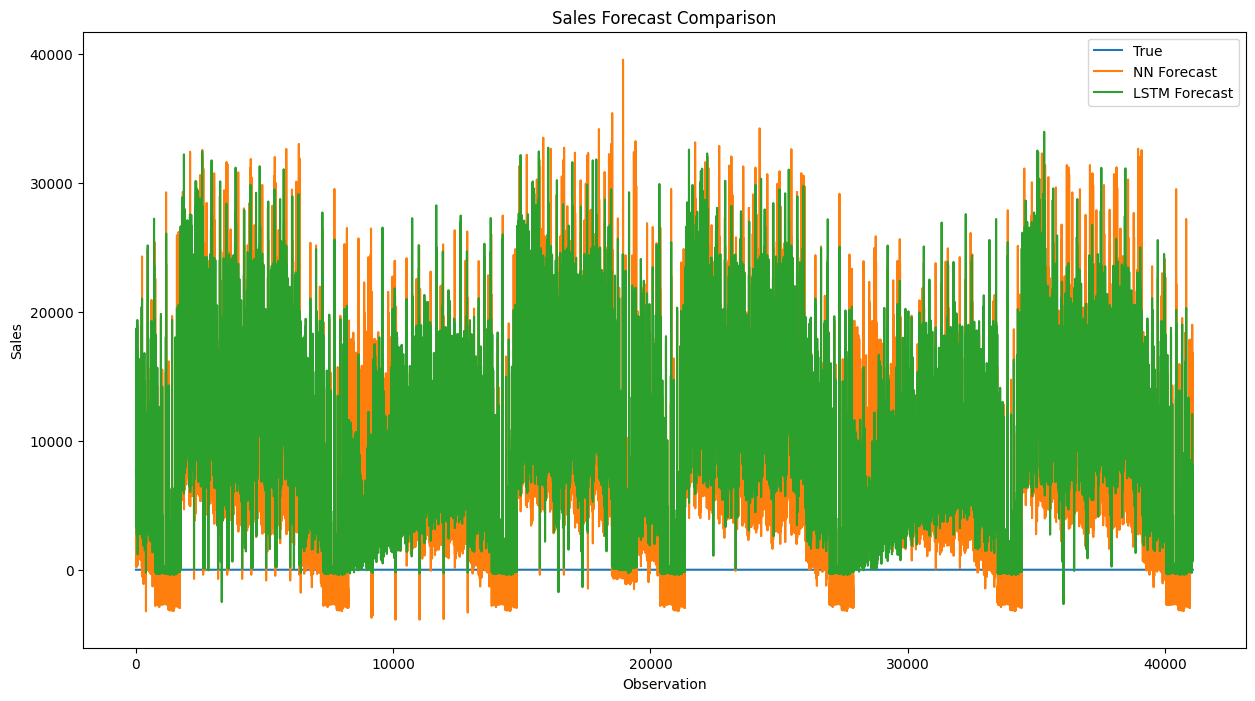

In [33]:
# Forecasting using the simple neural network (NN) model
nn_y_pred_test = model.predict(X_test_subset)

# Forecasting using the trained LSTM model
y_pred_lstm = rnn_model.predict(X_test_subset_lstm)

# Inverse transform the scaled predictions to the original scale
y_pred_original_scale_nn = scaler_y.inverse_transform(nn_y_pred_test)
y_pred_original_scale_lstm = scaler_y.inverse_transform(y_pred_lstm)

# Plotting the forecasts
plt.figure(figsize=(15, 8))
plt.plot(y_test_subset, label='True')                     # True sales values
plt.plot(y_pred_original_scale_nn, label='NN Forecast')   # Forecast using NN model
plt.plot(y_pred_original_scale_lstm, label='LSTM Forecast')  # Forecast using LSTM model
plt.title("Sales Forecast Comparison")
plt.xlabel('Observation')
plt.ylabel('Sales')
plt.legend()
plt.show()

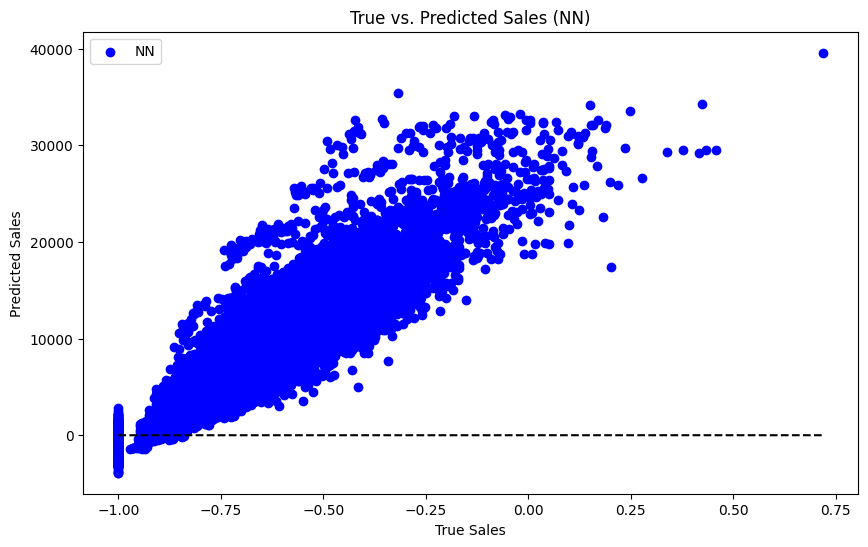

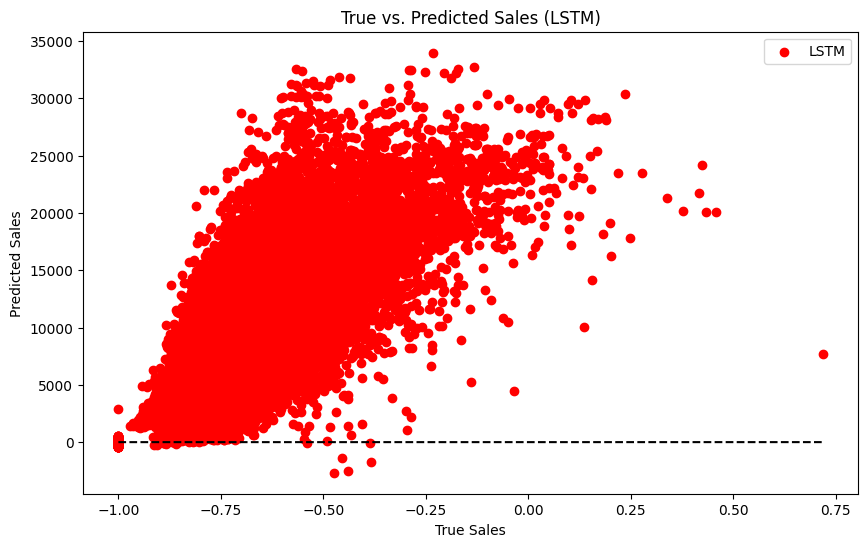

In [34]:
# Scatter plot of predicted vs. true sales values for NN model
plt.figure(figsize=(10, 6))
plt.scatter(y_test_subset, y_pred_original_scale_nn, color='blue', label='NN')
plt.plot([y_test_subset.min(), y_test_subset.max()], [y_test_subset.min(), y_test_subset.max()], color='black', linestyle='--')  # Add diagonal line for reference
plt.title('True vs. Predicted Sales (NN)')
plt.xlabel('True Sales')
plt.ylabel('Predicted Sales')
plt.legend()
plt.show()

# Scatter plot of predicted vs. true sales values for LSTM model
plt.figure(figsize=(10, 6))
plt.scatter(y_test_subset, y_pred_original_scale_lstm, color='red', label='LSTM')
plt.plot([y_test_subset.min(), y_test_subset.max()], [y_test_subset.min(), y_test_subset.max()], color='black', linestyle='--')  # Add diagonal line for reference
plt.title('True vs. Predicted Sales (LSTM)')
plt.xlabel('True Sales')
plt.ylabel('Predicted Sales')
plt.legend()
plt.show()

1284/1284 [==============================] - 2s 2ms/step


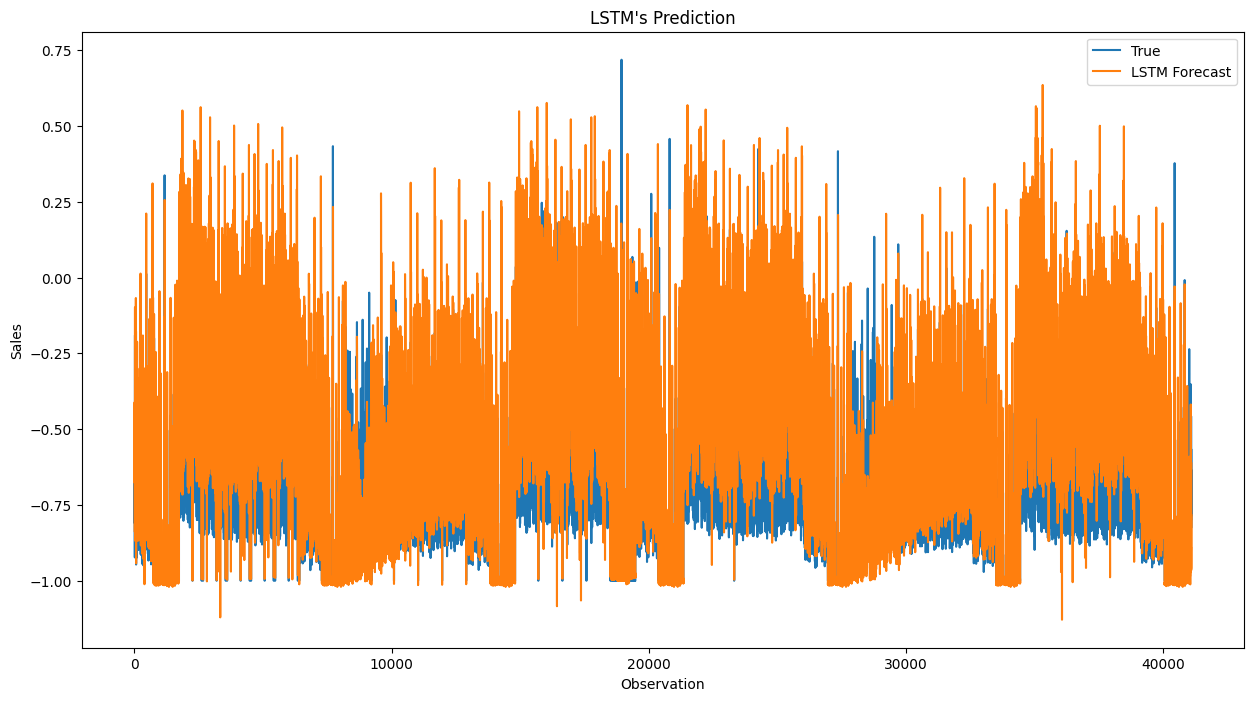

In [36]:
# Predict using the trained LSTM model
y_pred_lstm = rnn_model.predict(X_test_subset_lstm)

# Plotting the true sales values vs. LSTM forecasts
plt.figure(figsize=(15, 8))
plt.plot(y_test_subset_lstm, label='True')     # True sales values
plt.plot(y_pred_lstm, label='LSTM Forecast')   # Forecast using LSTM model
plt.title("LSTM's Prediction")
plt.xlabel('Observation')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [38]:
# Use the trained ANN model to predict sales values
y_pred_nn = model.predict(X_test_subset)

# Inverse scale the predicted sales values to their original scale
y_pred_original_scale = scaler_y.inverse_transform(y_pred_nn)

# Get the number of elements in the array
num_elements = len(y_pred_original_scale)

# Print or use the number of elements
print("Number of elements:", num_elements)

# Create an array of IDs starting from 1 to the number of elements
id_column = np.arange(1, num_elements + 1)

# Print the array of predicted sales values
print(y_pred_original_scale)

1284/1284 [==============================] - 2s 1ms/step
Number of elements: 41088
[[ 4146.9404]
 [ 4615.3486]
 [ 5738.6055]
 ...
 [ 6163.708 ]
 [ 6782.3413]
 [10339.008 ]]


In [39]:
# Create a DataFrame for Kaggle submission
kaggle_preds = pd.DataFrame({'Id': id_column, 'Sales': y_pred_original_scale.flatten()})

# Export the DataFrame to a CSV file
kaggle_preds.to_csv("Submission.csv", index=False)